# Pytorch homework
## 作業說明
這次的作業總共有5個部份，在每一個部份會有一些被註解框起來的區塊需要完成。
1. Preparation: 我們會利用CIFAR-10 dataset **(10%)**
2. Pytorch Module API: 在這邊我們會利用 nn.Module 建構出簡單的CNN（CNN架構請參照我們所提供） **(20%)**
3. Pytorch ModuleList API: 在這邊我們 nn.ModuleList 以及 nn.Module來建構出簡單的CNN（CNN架構請參照我們所提供） **(20%)**
4. Pytorch Sequential API: 在這邊我們 nn.Sequential 來建構出簡單的CNN（CNN架構請參照我們所提供） **(20%)**
5. CIFAR-10 open-ended challenge: 在這邊請大家建構屬於自己的CNN，並且盡量的得到高準確度，並解釋如何建構的 **(30%)**
    * 可以嘗試建構任意的layer, optimizer或是 hyperparameters等
    * 由於並不是所有同學都有GPU可以提供training，因此這題分數的分配不是根據最後的準確度而給分，而是達到baseline之後便會給於全部的分數
    * **Baseline: 65% on testing data**
    
## 作業繳交
* Deadline : 11/06 中午12:00
    * **遲交一天的打7折**
    * **遲交一天以上的打5折**
* 繳交方式 : 請繳交這個ipynb檔至moodle
* 作業命名 : (你的學號)\_(姓名)\_hw2.ipynb  (ex.F71112222_人工智.ipynb) 
    * **格式不對的話會扣10分！！！**
* 有任何問題歡迎寄信至我的信箱
    * 黃顯堯 e0928021388@gmail.com


## Part1 Preparation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np

from torchviz import make_dot, make_dot_from_trace

### Setting
你可以根據需求調整epochs, batch size等等的參數

In [2]:
CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
CIFAR_STD = [0.2023, 0.1994, 0.2010]

EPOCHS = 5
BATCH_SIZE = 64
PRINT_FREQ = 100
TRAIN_NUMS = 49000

CUDA = True

PATH_TO_SAVE_DATA = "./"

### Load CIFAR-10 dataset

In [3]:
data_transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
                  ])

train_data = datasets.CIFAR10(root=PATH_TO_SAVE_DATA, train=True,
                              download=True, transform=data_transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                          sampler=SubsetRandomSampler(range(TRAIN_NUMS)))
val_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
                        sampler=SubsetRandomSampler(range(TRAIN_NUMS, 50000)))



test_data = datasets.CIFAR10(root=PATH_TO_SAVE_DATA, train=False,
                             download=True, transform=data_transform)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


### GPU setting
可以根據選擇是否要使用gpu，在本次的作業沒有一定要使用到gpu，假如你沒有安裝cuda，torch.cuda.is_available會return False

In [4]:
if CUDA:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cpu


### Trainer
我們有提供Trainer讓同學可以training自己建構的model

In [5]:
class Trainer:
    def __init__(self, criterion, optimizer, device):
        self.criterion = criterion
        self.optimizer = optimizer
        
        self.device = device
        
    def train_loop(self, model, train_loader, val_loader):
        for epoch in range(EPOCHS):
            print("---------------- Epoch {} ----------------".format(epoch))
            self._training_step(model, train_loader, epoch)
            
            self._validate(model, val_loader, epoch)
    
    def test(self, model, test_loader):
            print("---------------- Testing ----------------")
            self._validate(model, test_loader, 0, state="Testing")
            
    def _training_step(self, model, loader, epoch):
        model.train()
        
        for step, (X, y) in enumerate(loader):
            X, y = X.to(self.device), y.to(self.device)
            N = X.shape[0]
            
            self.optimizer.zero_grad()
            outs = model(X)
            loss = self.criterion(outs, y)
            
            if step >= 0 and (step % PRINT_FREQ == 0):
                self._state_logging(outs, y, loss, step, epoch, "Training")
            
            loss.backward()
            self.optimizer.step()
            
    def _validate(self, model, loader, epoch, state="Validate"):
        model.eval()
        outs_list = []
        loss_list = []
        y_list = []
        
        with torch.no_grad():
            for step, (X, y) in enumerate(loader):
                X, y = X.to(self.device), y.to(self.device)
                N = X.shape[0]
                
                outs = model(X)
                loss = self.criterion(outs, y)
                
                y_list.append(y)
                outs_list.append(outs)
                loss_list.append(loss)
            
            y = torch.cat(y_list)
            outs = torch.cat(outs_list)
            loss = torch.mean(torch.stack(loss_list), dim=0)
            self._state_logging(outs, y, loss, step, epoch, state)
                
                
    def _state_logging(self, outs, y, loss, step, epoch, state):
        acc = self._accuracy(outs, y)
        print("[{:3d}/{}] {} Step {:03d} Loss {:.3f} Acc {:.3f}".format(epoch+1, EPOCHS, state, step, loss, acc))
            
    def _accuracy(self, output, target):
        batch_size = target.size(0)

        pred = output.argmax(1)
        correct = pred.eq(target)
        acc = correct.float().sum(0) / batch_size

        return acc

### Flatten

In [6]:
def flatten(x):
    ###############################################################################
    #                   TODO : Read the input in (N, C, W, H)                     #
    #                          "Flatten" into (N, C*W*H)                          #                   
    ###############################################################################
    #N:batch size，C:channel個數，H:高，W:寬 (特徵圖)
    N, C, H, W = x.size()
    x = x.view(x.size(0), -1)
    #print(N,C,H,W)
    #print(x.shape)
    ###############################################################################
    #                            END TO DO                                        #
    ###############################################################################
    
    return x

def test_flatten():
    x = torch.zeros((10, 3, 32, 32))
    print("Before flattening:", x.shape)
    print("After flattening:", flatten(x).shape) # Expected output (10, 3072) 
    
test_flatten()

Before flattening: torch.Size([10, 3, 32, 32])
After flattening: torch.Size([10, 3072])


## Part2 : Module API
In this part, you have to complete the implentation of CNN with Module API.
The network should have the following architectures.
1. A convolution layer with 16 3\*3 filters, with stride 2
2. ReLU
3. A convolution layer with 32 3\*3 filters, with stride 2
4. ReLU
5. Flatten
6. A fully-connected layer produce tensor to 200 
7. ReLU
8. A fully-connected layer produce score to 10 (classes)
![](./resource/model_architecture.png)

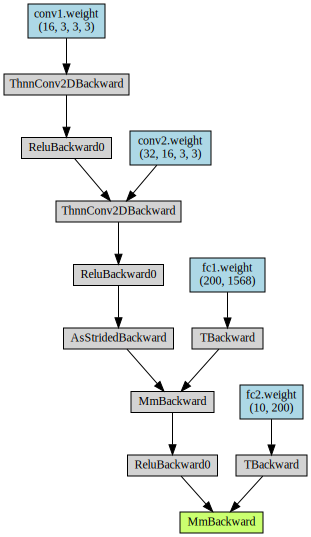

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1, self.conv2 = None, None
        self.fc1, self.fc2 = None, None
        ###############################################################################
        #       TODO : Set up the layer that you need to construct the model          #
        ###############################################################################
        #print(x.shape)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, bias=False)
        
        self.fc1 = nn.Linear(1568, 200, bias=False)
        self.fc2 = nn.Linear(200, 10, bias=False)
        #print(self)
        ###############################################################################
        #                            END TO DO                                        #
        ###############################################################################
        
        
    def forward(self, x):
        out = None
        ###############################################################################
        #            TODO : Implement the forward function. You should use            #
        #                   the layers you defined in __init__ and specify the        #
        #                   connectivity of those layers in forward()                 #
        ###############################################################################
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        #print(out)
        ###############################################################################
        #                            END TO DO                                        #
        ###############################################################################        

        return out
        

model = CNN()
x = torch.zeros((BATCH_SIZE, 3, 32, 32))
make_dot(model(x), params=dict(model.named_parameters())) # You can check if the picture is the same 
                                                          # as previous picture

### Train the model
Train the model and check the accuracy of training dataset and validation set

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-3, momentum=0.9)
trainer = Trainer(criterion, optimizer, device)
trainer.train_loop(model, train_loader, val_loader)
trainer.test(model, test_loader)

---------------- Epoch 0 ----------------
[  1/5] Training Step 000 Loss 2.310 Acc 0.062
[  1/5] Training Step 100 Loss 2.285 Acc 0.188
[  1/5] Training Step 200 Loss 2.213 Acc 0.344
[  1/5] Training Step 300 Loss 2.201 Acc 0.297
[  1/5] Training Step 400 Loss 1.990 Acc 0.344
[  1/5] Training Step 500 Loss 2.033 Acc 0.328
[  1/5] Training Step 600 Loss 1.941 Acc 0.312
[  1/5] Training Step 700 Loss 1.857 Acc 0.250
[  1/5] Validate Step 015 Loss 1.848 Acc 0.363
---------------- Epoch 1 ----------------
[  2/5] Training Step 000 Loss 1.659 Acc 0.516
[  2/5] Training Step 100 Loss 1.561 Acc 0.500
[  2/5] Training Step 200 Loss 1.870 Acc 0.312
[  2/5] Training Step 300 Loss 1.565 Acc 0.500
[  2/5] Training Step 400 Loss 1.698 Acc 0.422
[  2/5] Training Step 500 Loss 1.729 Acc 0.359
[  2/5] Training Step 600 Loss 1.649 Acc 0.406
[  2/5] Training Step 700 Loss 1.704 Acc 0.391
[  2/5] Validate Step 015 Loss 1.647 Acc 0.430
---------------- Epoch 2 ----------------
[  3/5] Training Step 000 Lo

## Part3 ModuleList API
In this part, you have to complete the implentation of CNN with ModuleList API and Module API.
The network should have the following architectures.
1. A convolution layer with 16 3\*3 filters, with stride 2
2. ReLU
3. A convolution layer with 32 3\*3 filters, with stride 2
4. ReLU
5. Flatten
6. A fully-connected layer produce tensor to 200 
7. ReLU
8. A fully-connected layer produce score to 10 (classes)
![](./resource/model_architecture.png)

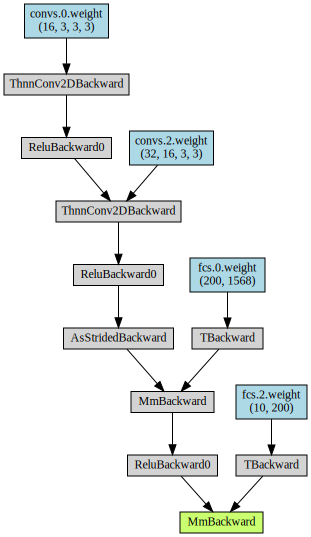

In [9]:
class ML(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs, self.fcs = nn.ModuleList(), nn.ModuleList()
        ###############################################################################
        #       TODO : Set up the layer that you need to construct the model          #
        ############################################################################### 
        
        self.convs=nn.ModuleList([
            nn.Conv2d(3, 16, kernel_size=3, stride=2, bias=False),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, bias=False),
            nn.ReLU()
        ])
        
        self.fcs = nn.ModuleList([
            nn.Linear(1568, 200, bias=False),
            nn.ReLU(),
            nn.Linear(200, 10, bias=False),
        ])
        #print(self.fcs)
        ###############################################################################
        #                            END TO DO                                        #
        ############################################################################### 
        
    def forward(self, x):
        out = None
        ###############################################################################
        #            TODO : Implement the forward function. You should use            #
        #                   the layers you defined in __init__ and specify the        #
        #                   connectivity of those layers in forward()                 #
        ###############################################################################          
#         for m in self.convs and n in self.fcs:
#             x = m(x)
#             print(m)
            
#         return x
#         out = x.reshape(out.size(0), -1)
#         print(out.shape)
#         x = self.fcs[0](x)
#         x = self.fcs[1](x)
#         for m in self.convs:
#             x = m(x)
#             #print(m)
#             return x
        
        x = self.convs[0](x)
        x = self.convs[1](x)
        x = self.convs[2](x)
        x = self.convs[3](x)
        x = x.reshape(x.size(0), -1)
        #print(x.shape)
        x = self.fcs[0](x)
        x = self.fcs[1](x)
        out = self.fcs[2](x)
        #print(out.shape)
        
        

        ###############################################################################
        #                            END TO DO                                        #
        ###############################################################################             
        return out
    
model = ML()
x = torch.zeros((BATCH_SIZE, 3, 32, 32))
make_dot(model(x), params=dict(model.named_parameters())) # You can check if the picture is the same 
                                                          # as previous picture

### Train the model
Train the model and check the accuracy of training dataset and validation set

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-3, momentum=0.9)
trainer = Trainer(criterion, optimizer, device)
trainer.train_loop(model, train_loader, val_loader)
trainer.test(model, test_loader)

---------------- Epoch 0 ----------------
[  1/5] Training Step 000 Loss 2.304 Acc 0.078
[  1/5] Training Step 100 Loss 2.287 Acc 0.125
[  1/5] Training Step 200 Loss 2.223 Acc 0.109
[  1/5] Training Step 300 Loss 2.212 Acc 0.188
[  1/5] Training Step 400 Loss 2.029 Acc 0.281
[  1/5] Training Step 500 Loss 1.697 Acc 0.391
[  1/5] Training Step 600 Loss 1.787 Acc 0.391
[  1/5] Training Step 700 Loss 1.970 Acc 0.328
[  1/5] Validate Step 015 Loss 1.839 Acc 0.351
---------------- Epoch 1 ----------------
[  2/5] Training Step 000 Loss 1.774 Acc 0.422
[  2/5] Training Step 100 Loss 1.808 Acc 0.422
[  2/5] Training Step 200 Loss 1.771 Acc 0.359
[  2/5] Training Step 300 Loss 1.985 Acc 0.281
[  2/5] Training Step 400 Loss 1.739 Acc 0.422
[  2/5] Training Step 500 Loss 1.728 Acc 0.328
[  2/5] Training Step 600 Loss 1.894 Acc 0.359
[  2/5] Training Step 700 Loss 1.664 Acc 0.500
[  2/5] Validate Step 015 Loss 1.652 Acc 0.432
---------------- Epoch 2 ----------------
[  3/5] Training Step 000 Lo

## Part4 Sequential
In this part, you have to complete the implentation of CNN with Sequential API.
The network should have the following architectures.
1. A convolution layer with 16 3\*3 filters, with stride 2
2. ReLU
3. A convolution layer with 32 3\*3 filters, with stride 2
4. ReLU
5. Flatten
6. A fully-connected layer produce tensor to 200 
7. ReLU
8. A fully-connected layer produce score to 10 (classes)
![](./resource/model_architecture.png)

In [11]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

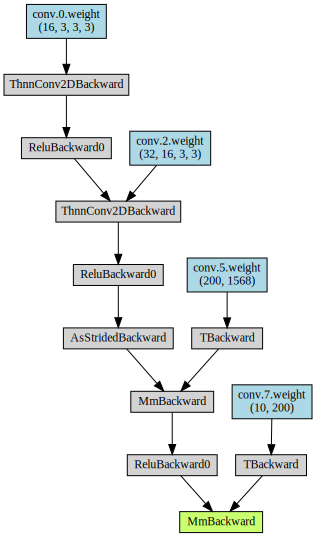

In [12]:
model = None
###############################################################################
#            TODO : Implement the Sequential API to complete the model        #
###############################################################################          
class seq(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, bias=False),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, bias=False),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1568, 200, bias=False),
            nn.ReLU(),
            nn.Linear(200, 10, bias=False))
        #print(self)
  
    def forward(self, x):
        out = self.conv(x)
        #print(out)
        return out
        

model = seq()
###############################################################################
#                            END TO DO                                        #
###############################################################################  


x = torch.zeros((BATCH_SIZE, 3, 32, 32))
make_dot(model(x), params=dict(model.named_parameters())) # You can check if the picture is the same 
                                                          # as previous picture

### Train the model
Train the model and check the accuracy of training dataset and validation set

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-3, momentum=0.9)
trainer = Trainer(criterion, optimizer, device)
trainer.train_loop(model, train_loader, val_loader)
trainer.test(model, test_loader)

---------------- Epoch 0 ----------------
[  1/5] Training Step 000 Loss 2.297 Acc 0.094
[  1/5] Training Step 100 Loss 2.259 Acc 0.125
[  1/5] Training Step 200 Loss 2.095 Acc 0.297
[  1/5] Training Step 300 Loss 2.114 Acc 0.234
[  1/5] Training Step 400 Loss 1.997 Acc 0.328
[  1/5] Training Step 500 Loss 1.998 Acc 0.203
[  1/5] Training Step 600 Loss 1.956 Acc 0.328
[  1/5] Training Step 700 Loss 1.842 Acc 0.359
[  1/5] Validate Step 015 Loss 1.851 Acc 0.365
---------------- Epoch 1 ----------------
[  2/5] Training Step 000 Loss 1.749 Acc 0.438
[  2/5] Training Step 100 Loss 1.728 Acc 0.406
[  2/5] Training Step 200 Loss 1.647 Acc 0.469
[  2/5] Training Step 300 Loss 1.695 Acc 0.375
[  2/5] Training Step 400 Loss 1.751 Acc 0.438
[  2/5] Training Step 500 Loss 1.680 Acc 0.344
[  2/5] Training Step 600 Loss 1.844 Acc 0.344
[  2/5] Training Step 700 Loss 1.805 Acc 0.328
[  2/5] Validate Step 015 Loss 1.624 Acc 0.432
---------------- Epoch 2 ----------------
[  3/5] Training Step 000 Lo

## Part 5 CIFAR-10 open-ended challenge
In this section, you can experiment with whatever ConvNet architecture you'd like on CIFAR-10
### Baseline : 65% on Testing data!!!

In [14]:
model = None
optimizer = None
###############################################################################
#                               TODO                                          #
###############################################################################          
class SEQ(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1, self.conv2 = None, None
        self.fc1, self.fc2 = None, None
        ###############################################################################
        #       TODO : Set up the layer that you need to construct the model          #
        ###############################################################################
        #print(x.shape)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc = nn.Linear(4608, 10)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
        

model = SEQ()
x = torch.zeros((BATCH_SIZE, 3, 32, 32))
make_dot(model(x), params=dict(model.named_parameters())) # You can check if the picture is the same 
                                                          # as previous picture
###############################################################################
#                            END TO DO                                        #
###############################################################################  



criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-3, momentum=0.9)
trainer = Trainer(criterion, optimizer, device)
trainer.train_loop(model, train_loader, val_loader)
trainer.test(model, test_loader)

---------------- Epoch 0 ----------------
[  1/5] Training Step 000 Loss 2.542 Acc 0.047
[  1/5] Training Step 100 Loss 1.572 Acc 0.406
[  1/5] Training Step 200 Loss 1.112 Acc 0.625
[  1/5] Training Step 300 Loss 1.427 Acc 0.453
[  1/5] Training Step 400 Loss 1.104 Acc 0.672
[  1/5] Training Step 500 Loss 1.056 Acc 0.641
[  1/5] Training Step 600 Loss 1.014 Acc 0.625
[  1/5] Training Step 700 Loss 1.259 Acc 0.547
[  1/5] Validate Step 015 Loss 1.106 Acc 0.602
---------------- Epoch 1 ----------------
[  2/5] Training Step 000 Loss 0.820 Acc 0.719
[  2/5] Training Step 100 Loss 1.054 Acc 0.656
[  2/5] Training Step 200 Loss 1.019 Acc 0.641
[  2/5] Training Step 300 Loss 0.847 Acc 0.750
[  2/5] Training Step 400 Loss 0.827 Acc 0.734
[  2/5] Training Step 500 Loss 0.774 Acc 0.797
[  2/5] Training Step 600 Loss 0.841 Acc 0.656
[  2/5] Training Step 700 Loss 0.724 Acc 0.688
[  2/5] Validate Step 015 Loss 0.977 Acc 0.662
---------------- Epoch 2 ----------------
[  3/5] Training Step 000 Lo

### 請解釋你如何建構的

## 架構說明
這比較相同的寫法nn.model、nn.sequential、nn.modulelist三種寫法，我發現在我的筆電上nn.Sequential的寫法準確率相對高一些故使用此。
1. 原本使用自己刻的結構：Batch Normalization和Convolution疊三次中間穿插Relu、Maxpooling、Softmax、Linear
   * Batch Normalization：想在每次做Convolution前再規格化一次
   * Bais：Convolution都加入Bias試圖學習到更多
   * Relu：由於Sigmoid疊出來可能產生gradient vanish問題，故使用Relu
   * Maxpooling：Avepooling我覺得Maxpooling更有選鑿feature的感覺，故down-sampling採用Maxpooling
   * Softmax：在最後要分類時加入此
 * 結果：準確率超爛，因此開始探討問題，與新架構
 
2. 問題探討
   * Batch Normalization不管加在Convolution前還是後，效果好像都沒有很好
   * Softmax：加在最後一層好像也沒有特別利於分類
 
3. 新架構(目前版本)：
   * 與舊架構少了兩次的Batch Normalization
   * 雖然我覺得Batch Normalization效果好像沒有很好，但我覺得他還是有它存在的必要
   * 拔掉Softmax
 * 結果：準確率大幅提升(0.7左右)
 
4. 新想法
   * 由於電腦資源有限因此並沒有疊很多層
   * 若有更好資源--Convolution：128層在往下到516；Linear：4608慢慢往下降而不是一次壓成10，準確率應該可以到達8成5